In [42]:
from flask import Flask, request, render_template_string
from bs4 import BeautifulSoup
import re
import pandas as pd
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import gensim.downloader as api
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import time
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from gensim.models import CoherenceModel, LdaModel, LdaMulticore
from gensim.corpora import Dictionary
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk
import tqdm
from nltk.stem import WordNetLemmatizer
import os
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import webbrowser
from nltk.util import ngrams
import torch
import random
import nest_asyncio
import threading
from sklearn.decomposition import TruncatedSVD
from sklearn.mixture import GaussianMixture
import gensim
from gensim import corpora


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/hadash/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hadash/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/hadash/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
gensim.utils.random.seed(SEED)

In [3]:
def save_claims_df(claims_df, filename='claims.csv'):
    claims_df.to_csv(filename)


def load_claims_df(filename='claims.csv'):
    return pd.read_csv(filename, index_col='Claim Number')

In [4]:
def preprocess_text(paragraph):
    # Preprocess claim text
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    custom_stop_words = {"first", "second", "third", "fourth", "claim", "wherein", "claimed", "characterized",
                         "comprises", "apparatus", "said", "comprising", "comprises", "described",
                         "one", "two", "three", "four", "according"
                         , "least", "method", "configuration", "configured", "data", "system", "device", "medium"}  # Removing manually inspected patent-claim specific stop-words
    stop_words.update(custom_stop_words)
    stop_words.update(map(str, range(1000)))  # Numbers are now stop words

    # Text cleaning
    paragraph = paragraph.lower()  # Convert to lowercase
    paragraph = paragraph.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation

    # Tokenization
    tokens = word_tokenize(paragraph)  # Split text into words

    # Stop words removal and Lemmatization
    processed_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    # Generate bigrams and trigrams
    bigrams = ['_'.join(bigram) for bigram in ngrams(processed_tokens, 2)]
    trigrams = ['_'.join(trigram) for trigram in ngrams(processed_tokens, 3)]

    # Combine unigrams, bigrams, and trigrams
    final_tokens = processed_tokens + bigrams + trigrams

    # Join tokens back into a single string for vectorization
    return ' '.join(final_tokens)

In [5]:
def google_patents_top_100_to_patent_url_list(top_100_url):
    # A function that recieves the url of a 100 search results from google patents, and returns the url of all of those search results
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.binary_location = "/Applications/Brave Browser.app/Contents/MacOS/Brave Browser"

    driver = webdriver.Chrome(options=chrome_options)

    driver.get(top_100_url)
    time.sleep(5)

    # Find elements by class name
    patents_classes = driver.find_elements(By.CSS_SELECTOR, '.result-title.style-scope.search-result-item')
    patent_urls = []
    for c in patents_classes:
        patent_url = c.get_attribute('data-result')
        patent_urls.append('https://patents.google.com/' + patent_url)

    driver.quit()
    return patent_urls


def Claim_to_clean(text):
    # Regular expression to find the pattern: number + "." + space. Strings which are not infact claims are returned as None
    try:
        pattern = r"\d+\.\s"
        match = re.search(pattern, text).group()
        split_text = text.split(match, 1)
        return text.split(match, 1)[1]
    except:
        return None


def Patent_url_to_claim_df(patent_url):
    # A function that inputs a patent's url, outputs a df of its claims
    patent_url = requests.get(patent_url)
    doc = BeautifulSoup(patent_url.text, "html.parser")
    claims_html = doc.find_all(class_="claim-text")
    claims_list = []
    # Put all claims in a list, without indices
    for claim in claims_html:
        clean_claim = Claim_to_clean(claim.text.strip())
        if clean_claim is not None:
            claims_list.append(clean_claim)

    # Removing duplicates from the list
    claims_list = list(dict.fromkeys(claims_list))

    # List to Pandas table
    df = pd.DataFrame(claims_list, columns=['Claim'])
    df['Claim Number'] = df.index + 1
    df = df[['Claim Number', 'Claim']]
    df.set_index('Claim Number', inplace=True)

    return df

In [6]:
def make_claims_df(pages_to_add=3):
    # A function that makes the entire dataset.
    patent_url_list = ["https://patents.google.com/patent/GB2478972A/en?q=(phone)&oq=phone",
                       "https://patents.google.com/patent/US9634864B2/en?oq=US9634864B2",
                       "https://patents.google.com/patent/US9980046B2/en?oq=US9980046B2"
                       ]  # The three patents given in the task
    for search_page in range(pages_to_add):
        search_page_url = "https://patents.google.com/?q=(Mobile+Communication)&num=100&oq=Mobile+Communication&sort=new&page="
        search_page_url += str(search_page)  # iterate through search pages
        patent_url_list += google_patents_top_100_to_patent_url_list(search_page_url)

    all_patent_df = []
    for patent_url in patent_url_list:
        all_patent_df.append(Patent_url_to_claim_df(patent_url))

    all_claims = pd.concat(all_patent_df)
    all_claims['Claim'] = all_claims['Claim'].apply(preprocess_text)
    all_claims = all_claims.dropna(subset=['Claim'])
    return all_claims

In [7]:
def compute_coherence_values(model, texts, dictionary):
    coherence_model_lda = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model_lda.get_coherence()


def get_most_related_word(words):
    # Filter out words not present in the model's vocabulary
    # Load the Google News word2vec model
    model = api.load('word2vec-google-news-300')
    valid_words = [word for word in words if word in model]
    if not valid_words:
        return "Unnamed"
    # Find the word most related to the given words using the model
    related_word = model.most_similar(positive=valid_words, topn=1)
    if related_word:
        return related_word[0][0]
    return "Unnamed"

In [8]:
    check_Task_1 = False
    filename = 'claims.csv'
    if os.path.exists(filename) and not check_Task_1:
        all_claims = load_claims_df(filename)
    else:
        all_claims = make_claims_df()
        save_claims_df(all_claims, filename)
    all_claims = all_claims.dropna(subset=['Claim'])
    tfidf_vectorizer = TfidfVectorizer(stop_words="english")
    X_tfidf = tfidf_vectorizer.fit_transform(all_claims['Claim'])
    
    # Convert the 'Claim' column to a list of strings
    all_claims_LDA = all_claims['Claim'].tolist()

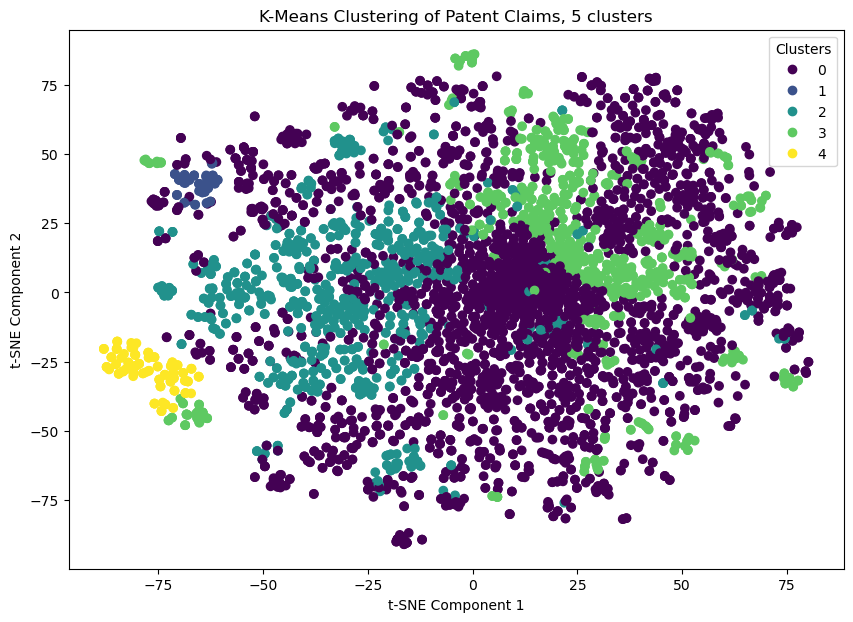

In [9]:
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=300, tol=1e-4, random_state=SEED)
kmeans.fit(X_tfidf)
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=SEED)
X_tsne = tsne.fit_transform(X_tfidf.toarray())

# Plot the clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans.labels_, cmap='viridis')

# Add legend
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("K-Means Clustering of Patent Claims, 5 clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [ ]:
#Clustering doesn't look too good. We have chosen 5 clusters as our choice. But lets see how the algorithm
#behaves as we change the number of clusters

Calculating for k = 2
Calculating for k = 3
Calculating for k = 4
Calculating for k = 5
Calculating for k = 6
Calculating for k = 7
Calculating for k = 8
Calculating for k = 9
Calculating for k = 10
Calculating for k = 11
Calculating for k = 12
Calculating for k = 13
Calculating for k = 14
Calculating for k = 15
Calculating for k = 16
Calculating for k = 17
Calculating for k = 18
Calculating for k = 19
Calculating for k = 20
Calculating for k = 21
Calculating for k = 22
Calculating for k = 23
Calculating for k = 24
Calculating for k = 25
Calculating for k = 26
Calculating for k = 27
Calculating for k = 28
Calculating for k = 29


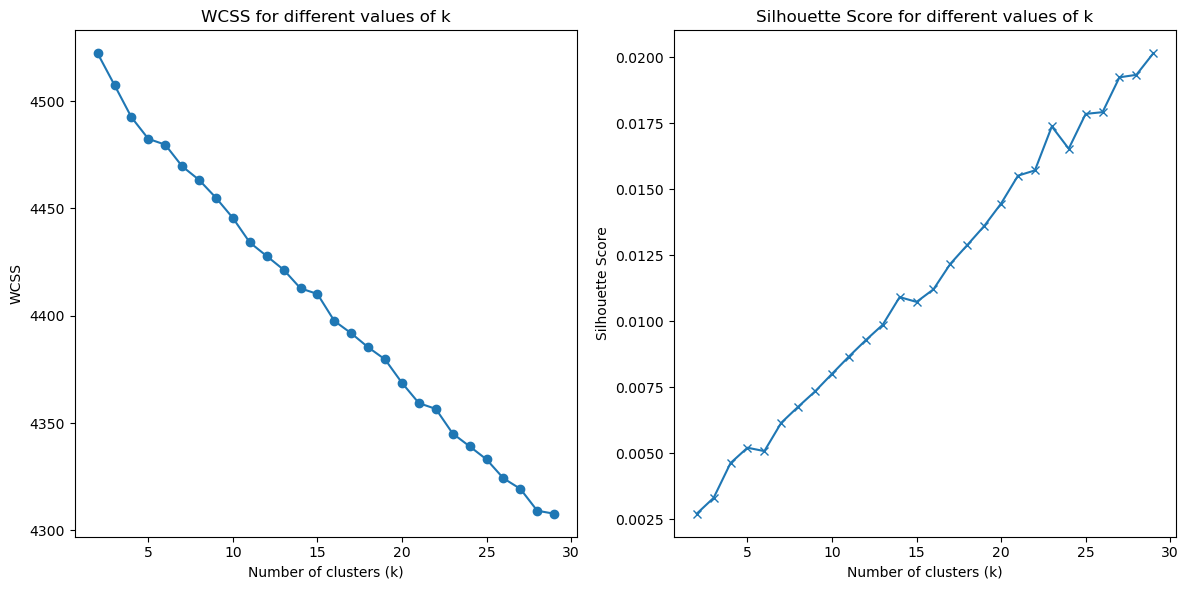

In [10]:
wcss = []
silhouette_scores = []
K = range(2, 30)

for k in K:
    print(f"Calculating for k = {k}")
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, tol=1e-4, random_state=SEED)
    kmeans.fit(X_tfidf)

    # Append WCSS (inertia) to the list
    wcss.append(kmeans.inertia_)

    # Calculate and append silhouette score to the list
    silhouette_avg = silhouette_score(X_tfidf, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plot the WCSS and Silhouette scores
plt.figure(figsize=(12, 6))

# Plot WCSS
plt.subplot(1, 2, 1)
plt.plot(K, wcss, marker='o')
plt.title('WCSS for different values of k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')

# Plot Silhouette scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, marker='x')
plt.title('Silhouette Score for different values of k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [ ]:
#We can see that the WCSS decreases as we increase cluster size. Proportionally, the silhouette score increases.
#Let's see what happens when k=50

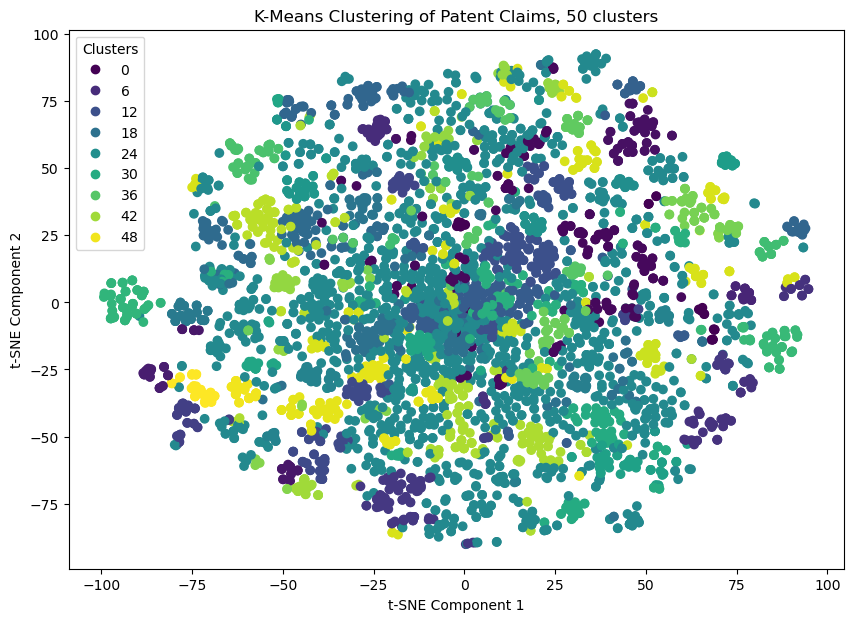

In [12]:
kmeans = KMeans(n_clusters=50, init='k-means++', n_init=10, max_iter=300, tol=1e-4, random_state=SEED)
kmeans.fit(X_tfidf)
tsne = TSNE(n_components=2, perplexity=20, learning_rate=200, random_state=SEED)
X_tsne = tsne.fit_transform(X_tfidf.toarray())

# Plot the clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans.labels_, cmap='viridis')

# Add legend
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("K-Means Clustering of Patent Claims, 50 clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [13]:
#A little bit better but still very non-informative. K-means clustering is a hard clustering method,
#which means it has to assign each component to a SINGLE cluster. The assignment deals with strictly
#Mobile Communications data, which means that inevitably, there will be a lot of overlap between clusters.
#To sum up - it seems that K-means Clustering isn't the right choice for us in this case. Let's explore with
#soft clustering methods. The first would be GMM.

In [14]:
#the GMM doesn't converge when dealing the the tfidf data. Too many dimensions. We would reducde the dimensionality
#using TruncatedSVD.

The sillhouete score is:0.26250650425696676


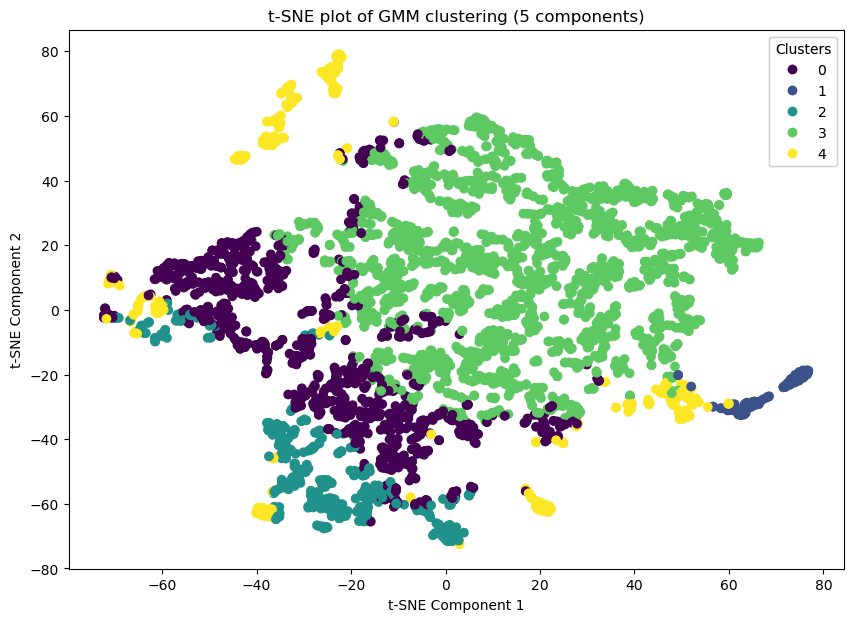

In [15]:
# GMM with dimensionality reduction

# Reduce dimensionality with TruncatedSVD based on the number of clusters
svd = TruncatedSVD(n_components=5, random_state=SEED)
X_reduced = svd.fit_transform(X_tfidf)

gmm = GaussianMixture(n_components=5, random_state=SEED, tol=1e-1, max_iter=100, n_init=100, covariance_type='diag')
gmm.fit(X_reduced)

labels = gmm.predict(X_reduced)
silhouette_avg = silhouette_score(X_reduced, labels)
print(f"The sillhouete score is:{silhouette_avg}")


# Perform t-SNE to reduce to 2D for visualization
tsne = TSNE(n_components=2, random_state=SEED, perplexity=30)  # Adjust perplexity if needed
X_tsne = tsne.fit_transform(X_reduced)

# Plot the clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis')

# Add legend
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

plt.title(f"t-SNE plot of GMM clustering ({5} components)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [16]:
#We can see that the results are better than the K-means clustering method, still not quite as good
#as we would like. Clusters are dense but not far apart. The yellow cluster is not continuous. It is a possibility that we have lost variablity in the SVD process.
#Let's try using TruncatedSVD with 25 components

The sillhouete score is:0.05632800615797412


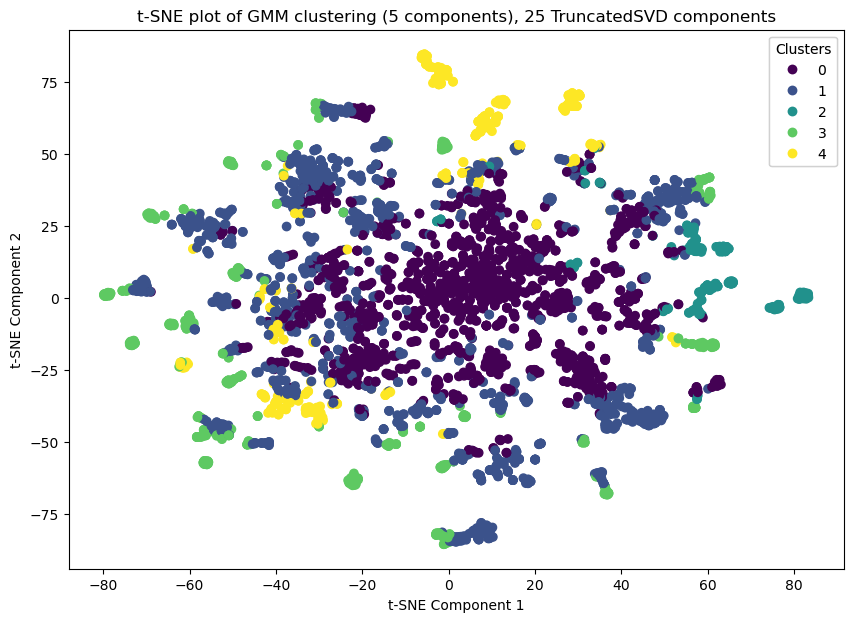

In [17]:
# GMM with dimensionality reduction - 25 components

# Reduce dimensionality with TruncatedSVD based on the number of clusters
svd = TruncatedSVD(n_components=25, random_state=SEED)
X_reduced = svd.fit_transform(X_tfidf)

gmm = GaussianMixture(n_components=5, random_state=SEED, tol=1e-1, max_iter=100, n_init=100, covariance_type='diag')
gmm.fit(X_reduced)

labels = gmm.predict(X_reduced)
silhouette_avg = silhouette_score(X_reduced, labels)
print(f"The sillhouete score is:{silhouette_avg}")


# Perform t-SNE to reduce to 2D for visualization
tsne = TSNE(n_components=2, random_state=SEED, perplexity=30)  # Adjust perplexity if needed
X_tsne = tsne.fit_transform(X_reduced)

# Plot the clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis')

# Add legend
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

plt.title(f"t-SNE plot of GMM clustering ({5} components), 25 TruncatedSVD components")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [18]:
#Sillouhette score has went down from 0.32 to -0.11, a significant drop. Clusters are overlapping. It seems that although we lose
#variability when we reduce dimensions, the loss in variability pays off.

In [19]:
#Let's experiment with the our final method - LDA:

In [20]:
#Some more processing for LDA
texts = [preprocess_text(doc).split() for doc in all_claims_LDA]
id2word = Dictionary(texts)
full_corpus = [id2word.doc2bow(text) for text in texts]

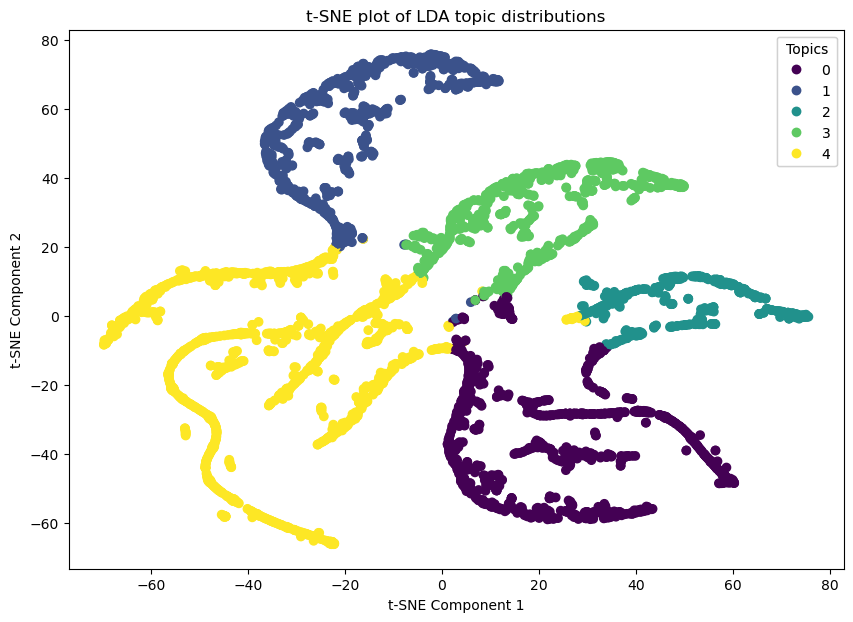

The coherence value for this model is:0.6266571301890248


In [21]:
# Train the LDA model
lda_check = LdaModel(corpus=full_corpus,
                         id2word=id2word,
                         num_topics=5,
                         random_state=SEED,
                         chunksize=100,
                         passes=10,
                         alpha=0.2,
                         eta=0.2)
# Get the topic distribution for each document
topic_distributions = [lda_check.get_document_topics(doc, minimum_probability=0) for doc in full_corpus]

# Convert the topic distributions to a NumPy array
X_lda = np.array([[topic_prob for _, topic_prob in doc_topics] for doc_topics in topic_distributions])


# Apply t-SNE
tsne = TSNE(n_components=2, random_state=SEED, perplexity=30)
X_tsne = tsne.fit_transform(X_lda)

# Plot the clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=[np.argmax(x) for x in X_lda], cmap='viridis')

# Add legend
legend1 = plt.legend(*scatter.legend_elements(), title="Topics")
plt.gca().add_artist(legend1)

plt.title("t-SNE plot of LDA topic distributions")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

print(f"The coherence value for this model is:{compute_coherence_values(lda_check, texts, id2word)}")

In [22]:
#It seems like the clusters are dense and seperate from one another, so far - it seems like the best fit.

In [23]:
#We will pick the model for Task 3. As we discussed before, KMM doesn't seem like a good fit due to its hard clustering
#property. GMM is also not a good fit because names are need to be made for each cluster. As we have seen, GMM improves drastically
#when we project it into a lower dimensional space. We may cluster better, but that clustering is less interpretable as the original
#features are now gone. That leaves us with the LDA model. It showed the best clustering, and it is more interpretable than the GMM.

#Let's tune the hyperparameters and further analyze this model. For the hyperparameter tuning part we would use LdaMulticore,
#because it is faster. Although it is fast, it is not reproducable. We would pick the optimal hyperparameters and then retrain
#with them using LdaModel

In [35]:
texts = [preprocess_text(doc).split() for doc in all_claims_LDA]
id2word = Dictionary(texts)
full_corpus = [id2word.doc2bow(text) for text in texts]

alpha = [0.1, 0.3, 0.5, 0.7, 0.9]
beta = [0.1, 0.3, 0.5, 0.7, 0.9]
model_results = {'Alpha': [], 'Beta': [], 'Coherence': []}

pbar = tqdm.tqdm(total=(len(beta) * len(alpha)))
for a in alpha:
    for b in beta:
        lda_model = LdaMulticore(corpus=full_corpus,
                                 id2word=id2word,
                                 num_topics=5,
                                 random_state=SEED,
                                 chunksize=100,
                                 passes=10,
                                 alpha=a,
                                 eta=b)

        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence = coherence_model.get_coherence()

        model_results['Alpha'].append(a)
        model_results['Beta'].append(b)
        model_results['Coherence'].append(coherence)

        pbar.update(1)
pbar.close()

df_model_results = pd.DataFrame(model_results)
print(df_model_results.to_string(index=False))

max_coherence_index = df_model_results['Coherence'].idxmax()
chosen_alpha = df_model_results.loc[max_coherence_index, 'Alpha']
chosen_beta = df_model_results.loc[max_coherence_index, 'Beta']

print(f"Chosen alpha: {chosen_alpha}")
print(f"Chosen beta: {chosen_beta}")

100%|████████████████████████████████████████████████████████████████████| 25/25 [32:02<00:00, 76.92s/it]

 Alpha  Beta  Coherence
   0.1   0.1   0.556696
   0.1   0.3   0.561464
   0.1   0.5   0.562212
   0.1   0.7   0.557210
   0.1   0.9   0.541628
   0.3   0.1   0.562621
   0.3   0.3   0.527843
   0.3   0.5   0.556321
   0.3   0.7   0.552435
   0.3   0.9   0.530463
   0.5   0.1   0.570421
   0.5   0.3   0.528231
   0.5   0.5   0.520369
   0.5   0.7   0.565990
   0.5   0.9   0.584398
   0.7   0.1   0.546610
   0.7   0.3   0.466459
   0.7   0.5   0.559195
   0.7   0.7   0.569416
   0.7   0.9   0.625364
   0.9   0.1   0.519019
   0.9   0.3   0.494586
   0.9   0.5   0.536066
   0.9   0.7   0.611436
   0.9   0.9   0.593343
Chosen alpha: 0.7
Chosen beta: 0.9


In [25]:
#We have chosen the optimal hyper-parameters to maximize coherence - alpha 0.3, beta 0.1.

In [36]:
best_model = LdaModel(corpus=full_corpus,
                                     id2word=id2word,
                                     num_topics=5,
                                     random_state=SEED,
                                     chunksize=100,
                                     passes=10,
                                     alpha=chosen_alpha,
                                     eta=chosen_beta)

In [37]:
final_coherence = compute_coherence_values(best_model, texts, id2word)
print(f"The final coherence is: {final_coherence}")

The final coherence is: 0.5078961307090311


In [38]:
#Let's see how well this model works!

In [39]:
term_ratios = {}
cluster_names = {}
for i in range(5):
    term_ratios[i] = {}
    topic_terms = best_model.get_topic_terms(i, topn=20)  # Limiting to top 20 terms for efficiency
    for term_id, term_prob in topic_terms:
        term = id2word[term_id]
        overall_occurrence = sum([freq for doc in full_corpus for id, freq in doc if id == term_id])
        term_ratios[i][term] = term_prob / overall_occurrence

for topic, terms in term_ratios.items():
    sorted_terms = sorted(terms.items(), key=lambda item: item[1], reverse=True)
    top_5_terms = [term for term, _ in sorted_terms[:5]]
    cluster_name = get_most_related_word(top_5_terms)
    cluster_names[topic] = cluster_name
    print(f'Topic {topic} ({cluster_name}):', top_5_terms)

# Visualize topics using pyLDAvis and save to HTML
vis = gensimvis.prepare(best_model, full_corpus, id2word)
pyLDAvis.save_html(vis, 'lda_vis.html')

Topic 0 (notches): ['notch', '2d_image', '2dimage', 'teeth', '2d']
Topic 1 (intersections): ['intersection', 'vehicular_control', 'vehicularcontrol_controlsystem', 'vehicularcontrol', 'vehicularcontrolsystem']
Topic 2 (±_###V): ['systemcontroller', 'load', 'satellite', 'resource', 'valve']
Topic 3 (Earn_Rs.####/day_working): ['association', 'internet', 'computersystem', 'part', 'electronicdevice']
Topic 4 (pillars): ['conductive_member', 'conductivemember', 'semiconductor_pillar', 'semiconductorpillar', 'pillar']


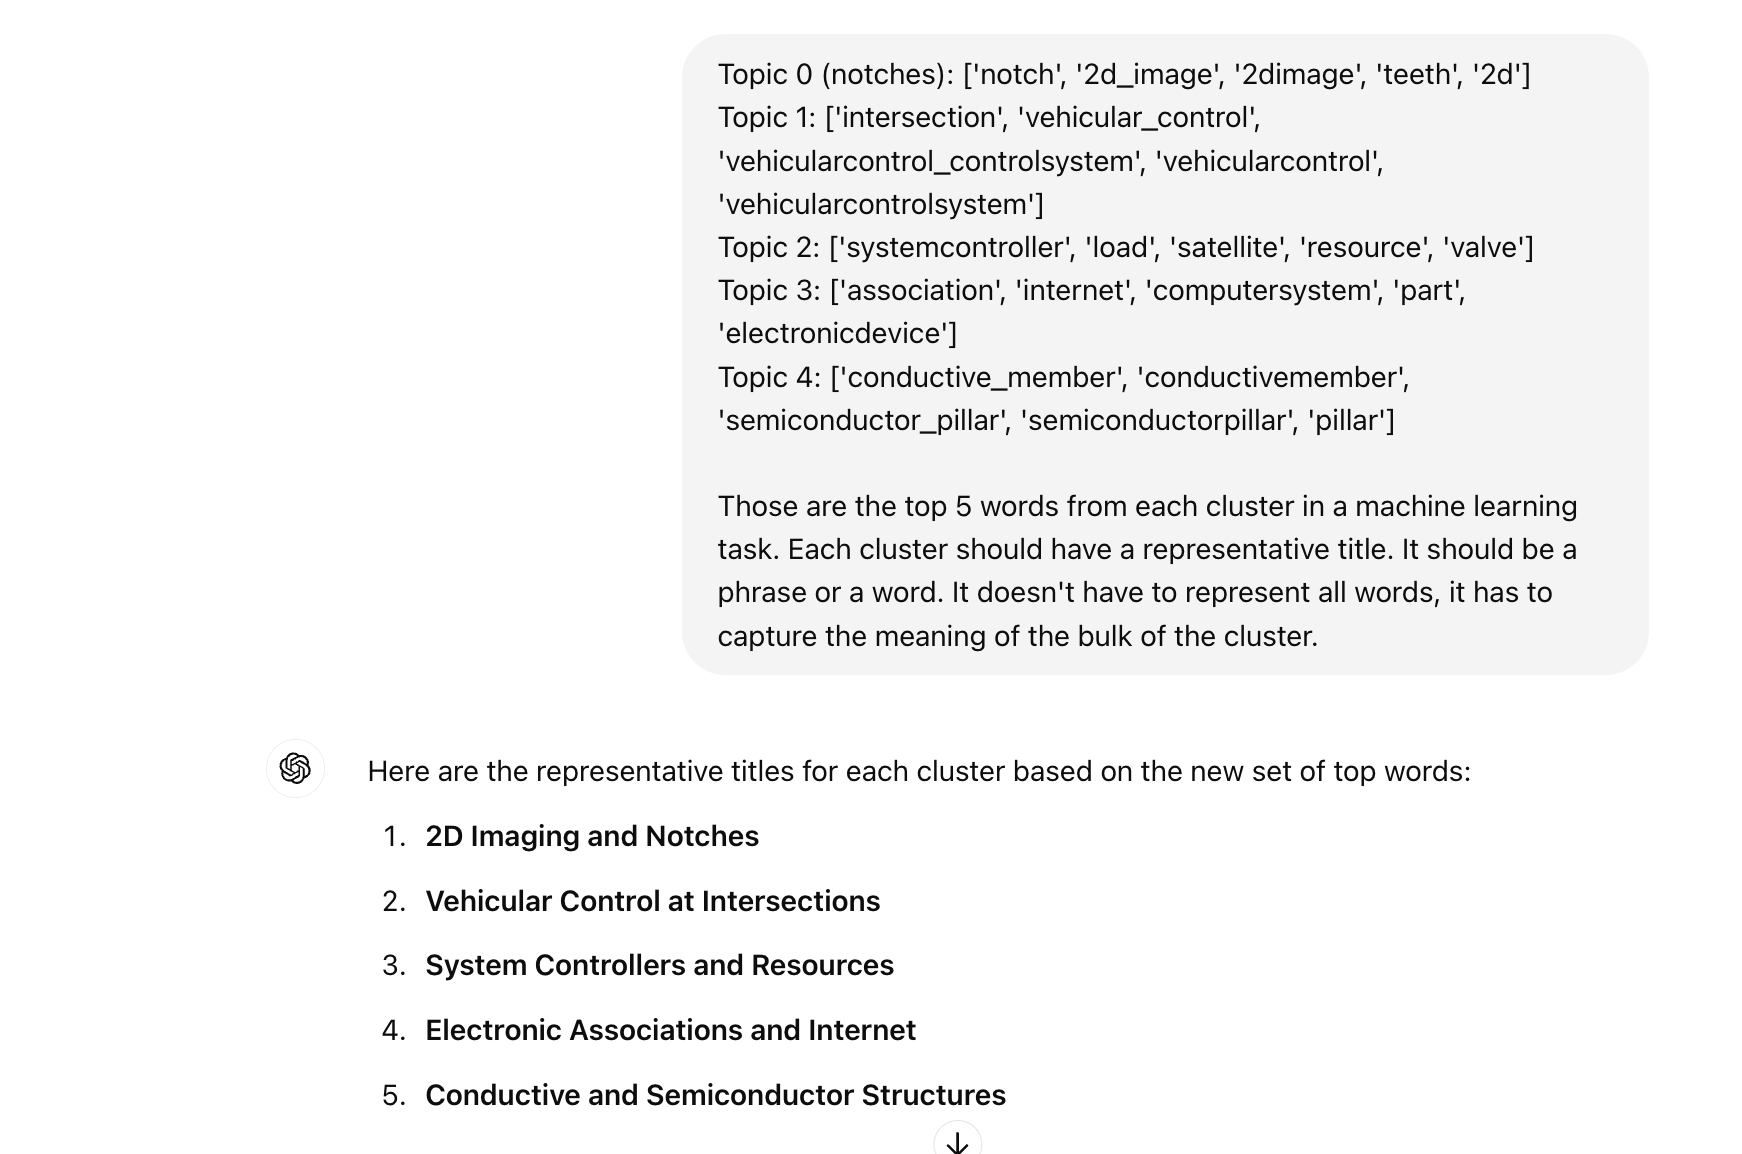

In [43]:
# try:
#     base_dir = os.path.dirname(__file__)
# except NameError:
#     base_dir = os.getcwd()

# # Define the save directory relative to the base directory
# save_dir = os.path.join(base_dir, 'models')

# # Create the directory if it doesn't exist
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)

# # Assuming best_model, id2word, and full_corpus are already defined

# # Save the LDA model
# best_model.save(os.path.join(save_dir, 'lda_model_final.gensim'))

# # Save the dictionary
# id2word.save(os.path.join(save_dir, 'dictionary_final.gensim'))

# # Save the corpus
# corpora.MmCorpus.serialize(os.path.join(save_dir, 'corpus_final.mm'), full_corpus)
